In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import kagglehub
import cv2
from PIL import Image
import random
from collections import Counter
from torch.nn import functional as F

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 15
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
SEED = 42

In [3]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
DATA_DIR = os.path.join(path, "Aerial_Landscapes")

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

minority_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [6]:
def create_imbalanced_dataset(dataset, class_names):
    class_indices = {i: [] for i in range(NUM_CLASSES)}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    target_counts = [int(800 - (i * (750 / (NUM_CLASSES - 1)))) for i in range(NUM_CLASSES)]
    sampled_indices = []
    class_distribution = {}
    
    for class_idx, indices in class_indices.items():
        target_count = min(target_counts[class_idx], len(indices))
        sampled_class_indices = np.random.choice(indices, target_count, replace=False)
        sampled_indices.extend(sampled_class_indices)
        class_distribution[class_names[class_idx]] = target_count
    
    print("Imbalanced class distribution:")
    for class_name, count in class_distribution.items():
        print(f"{class_name}: {count} images")
        
    return Subset(dataset, sampled_indices)

In [7]:
def get_class_weights(dataset):
    labels = []
    
    if isinstance(dataset, Subset):
        if hasattr(dataset.dataset, 'targets'):
            labels = [dataset.dataset.targets[idx] for idx in dataset.indices]
        elif hasattr(dataset.dataset, 'samples'):
            labels = [dataset.dataset.samples[idx][1] for idx in dataset.indices]
        else:
            for idx in dataset.indices:
                _, label = dataset.dataset[idx]
                labels.append(label)
    else:
        if hasattr(dataset, 'targets'):
            labels = dataset.targets
        elif hasattr(dataset, 'samples'):
            labels = [sample[1] for sample in dataset.samples]
        else:
            labels = [sample[1] for sample in dataset]
    
    class_counts = Counter(labels)
    total = sum(class_counts.values())
    class_weights = {cls: total / count for cls, count in class_counts.items()}
    max_weight = max(class_weights.values())
    class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
    weights = torch.FloatTensor([class_weights[i] for i in range(NUM_CLASSES)])
    return weights

In [8]:
def get_weighted_sampler(dataset):
    labels = []
    
    if isinstance(dataset, Subset):
        if hasattr(dataset.dataset, 'targets'):
            labels = [dataset.dataset.targets[idx] for idx in dataset.indices]
        elif hasattr(dataset.dataset, 'samples'):
            labels = [dataset.dataset.samples[idx][1] for idx in dataset.indices]
        else:
            for idx in dataset.indices:
                _, label = dataset.dataset[idx]
                labels.append(label)
    else:
        if hasattr(dataset, 'targets'):
            labels = dataset.targets
        elif hasattr(dataset, 'samples'):
            labels = [sample[1] for sample in dataset.samples]
        else:
            labels = [sample[1] for sample in dataset]
    
    class_counts = Counter(labels)
    weights = [1.0 / class_counts[labels[i]] for i in range(len(labels))]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

In [9]:
def get_weighted_sampler(dataset):
    if isinstance(dataset, Subset):
        if hasattr(dataset.dataset, 'targets'):
            labels = [dataset.dataset.targets[idx] for idx in dataset.indices]
        else:
            labels = [dataset.dataset.dataset.targets[idx] for idx in dataset.indices]
    else:
        labels = dataset.targets
    
    class_counts = Counter(labels)
    weights = [1.0 / class_counts[labels[i]] for i in range(len(labels))]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler


In [10]:
def get_custom_resnet50(num_classes=15, freeze_layers=True):
    model = models.resnet50(pretrained=True)

    if freeze_layers:
        for name, param in model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

    return model

In [11]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()
        
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)
        
        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
    
    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = torch.argmax(model_output, dim=1).item()
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0, target_class] = 1
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        weights = torch.mean(self.gradient, dim=(2, 3)).unsqueeze(-1).unsqueeze(-1)
        cam = torch.sum(weights * self.feature_maps, dim=1).squeeze(0)
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-10)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (input_image.shape[3], input_image.shape[2]))
        
        return cam, target_class

In [12]:
def apply_perturbation(image, perturbation_type, intensity=0.1):
    img_np = image.cpu().numpy().transpose(1, 2, 0)
    
    if perturbation_type == 'gaussian':
        noise = np.random.normal(0, intensity, img_np.shape)
        img_np = np.clip(img_np + noise, 0, 1)
    
    elif perturbation_type == 'blur':
        blur_size = int(intensity * 30) * 2 + 1 
        img_np = cv2.GaussianBlur(img_np, (blur_size, blur_size), 0)
    
    elif perturbation_type == 'occlusion':
        h, w = img_np.shape[:2]
        occlusion_size = int(intensity * min(h, w))
        x = np.random.randint(0, w - occlusion_size)
        y = np.random.randint(0, h - occlusion_size)
        img_np[y:y+occlusion_size, x:x+occlusion_size, :] = 0
    
    img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).float()
    return img_tensor


In [13]:
def train_model(model, train_loader, valid_loader, dataset_name=""):
    train_dataset = train_loader.dataset
    weights = get_class_weights(train_dataset).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LEARNING_RATE,
        weight_decay=1e-4
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=2, 
        verbose=True
    )
    
    best_f1 = 0
    best_model_state = None
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    print(f"\n===== Training model on {dataset_name} dataset =====")
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        print(f"Epoch {epoch+1} | Training Loss: {epoch_loss:.4f}")
        
        val_loss, val_f1 = evaluate_model(model, valid_loader, criterion=criterion, detailed=False)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        
        scheduler.step(val_loss)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print(f"New best model saved! F1: {val_f1:.4f}")
        
        print("-" * 50)
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    print(f"\nFinal Evaluation on Test Set ({dataset_name}):")
    _, _ = evaluate_model(model, valid_loader, criterion=criterion, detailed=True)
    
    return model, history


In [14]:
def evaluate_model(model, loader, criterion=None, detailed=False):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    avg_loss = running_loss / len(loader) if criterion else 0
    
    if detailed:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    
    return avg_loss, f1

In [15]:
def test_robustness(model, test_loader, grad_cam, num_samples=10):
    model.eval()
    perturbation_types = ['gaussian', 'blur', 'occlusion']
    intensities = [0.05, 0.1, 0.2, 0.3]
    sample_data = []
    for inputs, targets in test_loader:
        for i in range(min(len(inputs), num_samples - len(sample_data))):
            sample_data.append((inputs[i], targets[i]))
        if len(sample_data) >= num_samples:
            break
    
    results = {p_type: {intensity: [] for intensity in intensities} for p_type in perturbation_types}
    results['clean'] = {'original': []}
    
    for idx, (image, true_label) in enumerate(sample_data):
        image = image.unsqueeze(0).to(DEVICE)  
        
        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
            clean_pred = pred.item()
        
        clean_cam, _ = grad_cam.generate_cam(image, true_label.item())
        
        results['clean']['original'].append(clean_pred == true_label.item())
        
        for p_type in perturbation_types:
            for intensity in intensities:
                perturbed_img = apply_perturbation(image[0], p_type, intensity)
                perturbed_img = perturbed_img.unsqueeze(0).to(DEVICE)
                
                with torch.no_grad():
                    output = model(perturbed_img)
                    _, pred = torch.max(output, 1)
                    perturbed_pred = pred.item()
                
                perturbed_cam, _ = grad_cam.generate_cam(perturbed_img, true_label.item())
                
                results[p_type][intensity].append(perturbed_pred == true_label.item())
    
    print("\nModel Robustness Results:")
    print(f"Clean accuracy: {100 * sum(results['clean']['original']) / len(results['clean']['original']):.2f}%")
    
    for p_type in perturbation_types:
        print(f"\n{p_type.capitalize()} perturbation:")
        for intensity in intensities:
            accuracy = 100 * sum(results[p_type][intensity]) / len(results[p_type][intensity])
            print(f"  Intensity {intensity}: {accuracy:.2f}% accuracy")
    
    return results

In [16]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes


Creating imbalanced dataset...
Imbalanced class distribution:
Agriculture: 641 images
Airport: 651 images
Beach: 622 images
City: 637 images
Desert: 585 images
Forest: 532 images
Grassland: 478 images
Highway: 425 images
Lake: 371 images
Mountain: 317 images
Parking: 264 images
Port: 210 images
Railway: 157 images
Residential: 103 images
River: 50 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


===== Training model on Balanced dataset =====


Epoch 1/10: 100%|██████████| 300/300 [00:47<00:00,  6.31it/s]


Epoch 1 | Training Loss: 0.6394
New best model saved! F1: 0.9490
--------------------------------------------------


Epoch 2/10: 100%|██████████| 300/300 [00:46<00:00,  6.42it/s]


Epoch 2 | Training Loss: 0.1588
New best model saved! F1: 0.9705
--------------------------------------------------


Epoch 3/10: 100%|██████████| 300/300 [00:46<00:00,  6.44it/s]


Epoch 3 | Training Loss: 0.1068
New best model saved! F1: 0.9742
--------------------------------------------------


Epoch 4/10: 100%|██████████| 300/300 [00:47<00:00,  6.37it/s]


Epoch 4 | Training Loss: 0.0698
New best model saved! F1: 0.9742
--------------------------------------------------


Epoch 5/10: 100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Epoch 5 | Training Loss: 0.0561
--------------------------------------------------


Epoch 6/10: 100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Epoch 6 | Training Loss: 0.0499
New best model saved! F1: 0.9758
--------------------------------------------------


Epoch 7/10: 100%|██████████| 300/300 [00:46<00:00,  6.42it/s]


Epoch 7 | Training Loss: 0.0215
New best model saved! F1: 0.9767
--------------------------------------------------


Epoch 8/10: 100%|██████████| 300/300 [00:47<00:00,  6.30it/s]


Epoch 8 | Training Loss: 0.0235
--------------------------------------------------


Epoch 9/10: 100%|██████████| 300/300 [00:48<00:00,  6.21it/s]


Epoch 9 | Training Loss: 0.0165
New best model saved! F1: 0.9796
--------------------------------------------------


Epoch 10/10: 100%|██████████| 300/300 [00:48<00:00,  6.18it/s]


Epoch 10 | Training Loss: 0.0133
New best model saved! F1: 0.9812
--------------------------------------------------

Final Evaluation on Test Set (Balanced):
Accuracy: 0.9812
F1 Score (weighted): 0.9812

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       159
     Airport       0.95      0.99      0.97       149
       Beach       0.98      1.00      0.99       178
        City       0.96      0.99      0.98       163
      Desert       0.99      0.99      0.99       160
      Forest       1.00      0.98      0.99       142
   Grassland       0.97      0.99      0.98       173
     Highway       0.98      0.99      0.98       156
        Lake       0.98      0.98      0.98       172
    Mountain       0.98      0.98      0.98       179
     Parking       0.99      0.99      0.99       145
        Port       0.99      0.98      0.98       165
     Railway       0.98      0.95      0.96       141
 Residential   

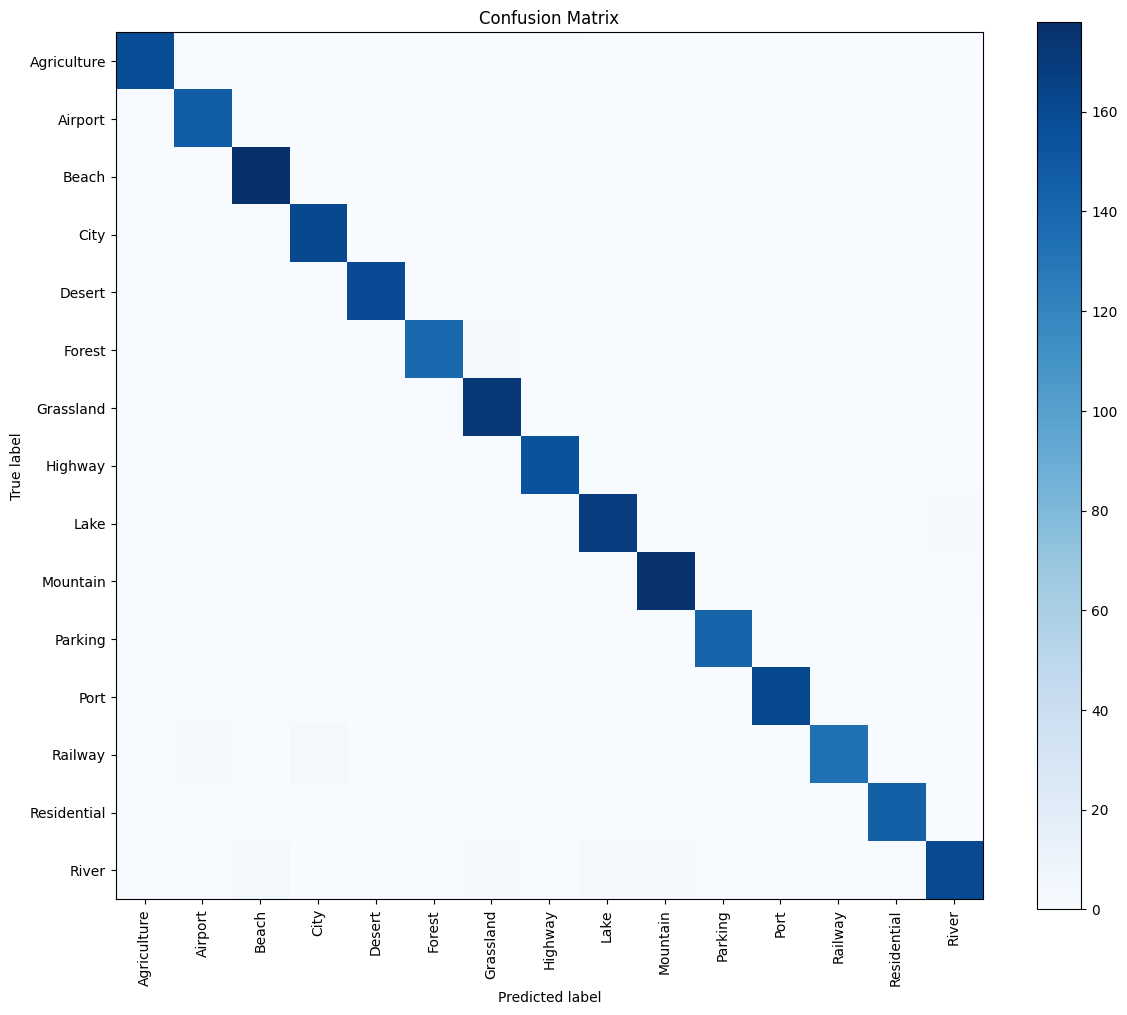

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



===== Training model on Imbalanced dataset =====


Epoch 1/10: 100%|██████████| 189/189 [00:29<00:00,  6.33it/s]


Epoch 1 | Training Loss: 0.9969
New best model saved! F1: 0.9401
--------------------------------------------------


Epoch 2/10: 100%|██████████| 189/189 [00:29<00:00,  6.37it/s]


Epoch 2 | Training Loss: 0.1951
New best model saved! F1: 0.9606
--------------------------------------------------


Epoch 3/10: 100%|██████████| 189/189 [00:29<00:00,  6.43it/s]


Epoch 3 | Training Loss: 0.1478
--------------------------------------------------


Epoch 4/10: 100%|██████████| 189/189 [00:29<00:00,  6.44it/s]


Epoch 4 | Training Loss: 0.1033
--------------------------------------------------


Epoch 5/10: 100%|██████████| 189/189 [00:29<00:00,  6.36it/s]


Epoch 5 | Training Loss: 0.0625
New best model saved! F1: 0.9655
--------------------------------------------------


Epoch 6/10: 100%|██████████| 189/189 [00:28<00:00,  6.58it/s]


Epoch 6 | Training Loss: 0.0415
New best model saved! F1: 0.9659
--------------------------------------------------


Epoch 7/10: 100%|██████████| 189/189 [00:28<00:00,  6.54it/s]


Epoch 7 | Training Loss: 0.0328
--------------------------------------------------


Epoch 8/10: 100%|██████████| 189/189 [00:29<00:00,  6.46it/s]


Epoch 8 | Training Loss: 0.0213
New best model saved! F1: 0.9726
--------------------------------------------------


Epoch 9/10: 100%|██████████| 189/189 [00:28<00:00,  6.54it/s]


Epoch 9 | Training Loss: 0.0196
New best model saved! F1: 0.9735
--------------------------------------------------


Epoch 10/10: 100%|██████████| 189/189 [00:30<00:00,  6.26it/s]


Epoch 10 | Training Loss: 0.0156
--------------------------------------------------

Final Evaluation on Test Set (Imbalanced):
Accuracy: 0.9688
F1 Score (weighted): 0.9684

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.98       159
     Airport       0.94      0.99      0.96       149
       Beach       0.98      0.99      0.99       178
        City       0.94      0.98      0.96       163
      Desert       0.96      0.99      0.98       160
      Forest       0.99      0.98      0.98       142
   Grassland       0.97      0.99      0.98       173
     Highway       0.98      0.98      0.98       156
        Lake       0.92      0.98      0.95       172
    Mountain       0.96      0.97      0.96       179
     Parking       0.99      0.99      0.99       145
        Port       0.99      0.99      0.99       165
     Railway       0.98      0.91      0.95       141
 Residential       0.99      0.97      0.98   

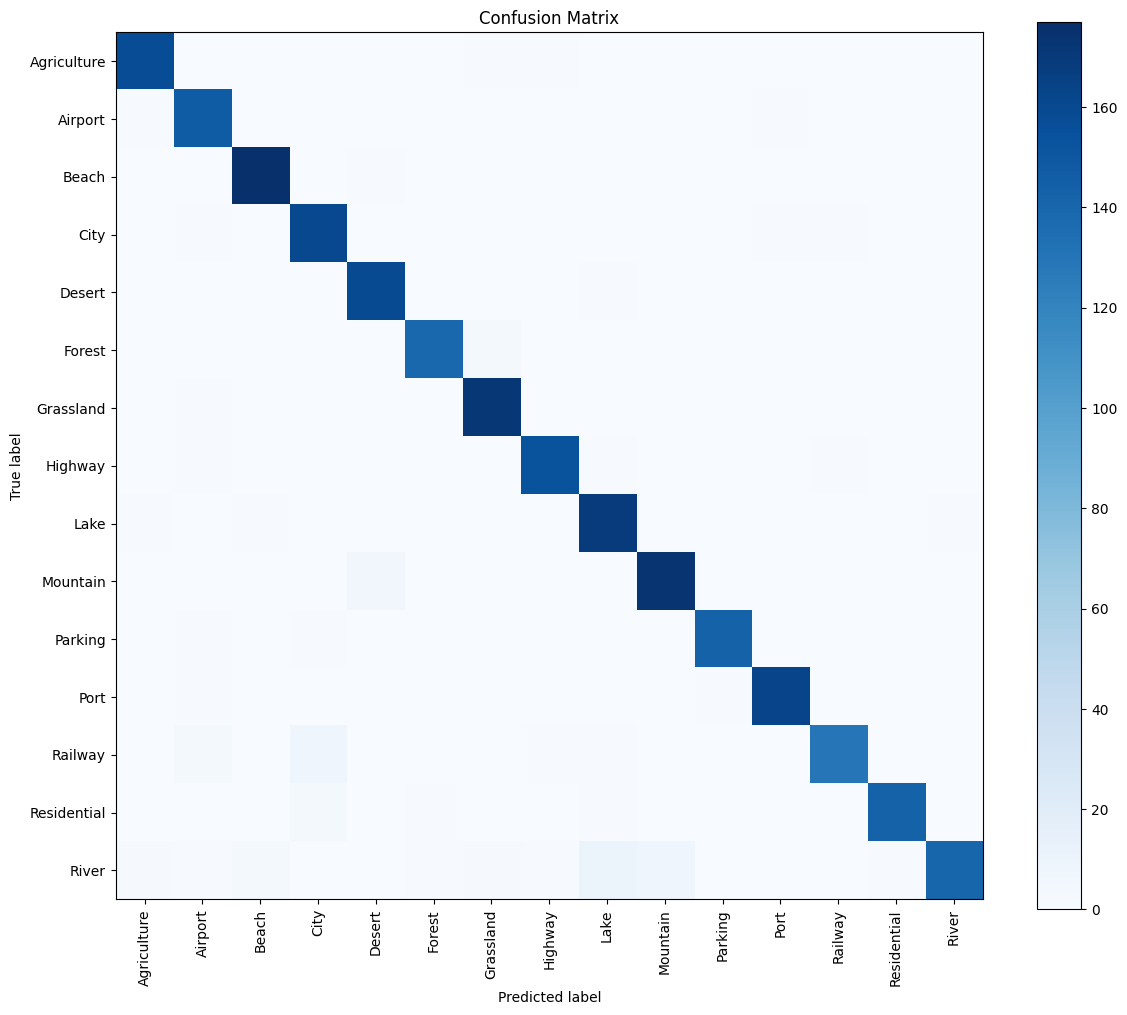


--- Model Comparison Summary ---
Balanced Model - Best Validation F1 Score: 0.9812
Imbalanced Model - Best Validation F1 Score: 0.9684

=== Robustness Testing on Balanced Model ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Model Robustness Results:
Clean accuracy: 100.00%

Gaussian perturbation:
  Intensity 0.05: 80.00% accuracy
  Intensity 0.1: 30.00% accuracy
  Intensity 0.2: 0.00% accuracy
  Intensity 0.3: 0.00% accuracy

Blur perturbation:
  Intensity 0.05: 100.00% accuracy
  Intensity 0.1: 100.00% accuracy
  Intensity 0.2: 90.00% accuracy
  Intensity 0.3: 50.00% accuracy

Occlusion perturbation:
  Intensity 0.05: 100.00% accuracy
  Intensity 0.1: 100.00% accuracy
  Intensity 0.2: 100.00% accuracy
  Intensity 0.3: 100.00% accuracy

=== Robustness Testing on Imbalanced Model ===

Model Robustness Results:
Clean accuracy: 100.00%

Gaussian perturbation:
  Intensity 0.05: 60.00% accuracy
  Intensity 0.1: 40.00% accuracy
  Intensity 0.2: 0.00% accuracy
  Intensity 0.3: 0.00% accuracy

Blur perturbation:
  Intensity 0.05: 100.00% accuracy
  Intensity 0.1: 100.00% accuracy
  Intensity 0.2: 90.00% accuracy
  Intensity 0.3: 80.00% accuracy

Occlusion perturbation:
  Intensity 0.05: 100.00% accuracy
  Intens

In [17]:
def main():
    train_len = int(0.8 * len(full_dataset))
    test_len = len(full_dataset) - train_len
    train_data, test_data = random_split(full_dataset, [train_len, test_len])
    
    train_data.dataset.transform = train_transforms
    test_data.dataset.transform = test_transforms
    
    print("\nCreating imbalanced dataset...")
    imbalanced_train_data = create_imbalanced_dataset(train_data, class_names)
    
    balanced_train_sampler = get_weighted_sampler(train_data)
    balanced_train_loader = DataLoader(
        train_data, 
        batch_size=BATCH_SIZE, 
        sampler=balanced_train_sampler
    )
    
    imbalanced_train_sampler = get_weighted_sampler(imbalanced_train_data)
    imbalanced_train_loader = DataLoader(
        imbalanced_train_data, 
        batch_size=BATCH_SIZE, 
        sampler=imbalanced_train_sampler
    )
    
    test_loader = DataLoader(
        test_data, 
        batch_size=BATCH_SIZE
    )
    
    balanced_model = get_custom_resnet50(num_classes=NUM_CLASSES, freeze_layers=True).to(DEVICE)
    balanced_model, balanced_history = train_model(
        balanced_model, 
        balanced_train_loader, 
        test_loader,
        dataset_name="Balanced"
    )
    
    imbalanced_model = get_custom_resnet50(num_classes=NUM_CLASSES, freeze_layers=True).to(DEVICE)
    imbalanced_model, imbalanced_history = train_model(
        imbalanced_model, 
        imbalanced_train_loader, 
        test_loader,
        dataset_name="Imbalanced"
    )

    print("\n--- Model Comparison Summary ---")
    print(f"Balanced Model - Best Validation F1 Score: {balanced_history['val_f1'][-1]:.4f}")
    print(f"Imbalanced Model - Best Validation F1 Score: {imbalanced_history['val_f1'][-1]:.4f}")
    
    balanced_grad_cam = GradCAM(balanced_model, balanced_model.layer4[-1])
    imbalanced_grad_cam = GradCAM(imbalanced_model, imbalanced_model.layer4[-1])
    
    print("\n=== Robustness Testing on Balanced Model ===")
    balanced_robustness = test_robustness(balanced_model, test_loader, balanced_grad_cam)
    
    print("\n=== Robustness Testing on Imbalanced Model ===")
    imbalanced_robustness = test_robustness(imbalanced_model, test_loader, imbalanced_grad_cam)
    
    balanced_grad_cam.remove_hooks()
    imbalanced_grad_cam.remove_hooks()

    print("\nExperiment completed successfully!")

if __name__ == "__main__":
    main()